To benchmark the execution time of python function we used the library function process_time() before and after the function execution.

### time.process_time() → float¶
Return the value (in fractional seconds) of the sum of the system and user CPU time of the current process. It does not include time elapsed during sleep. It is process-wide by definition. The reference point of the returned value is undefined, so that only the difference between the results of consecutive calls is valid.

*New in version 3.3.*

In [2]:
import time

start = time.process_time()
# your function here
end = time.process_time()
print(end - start)

3.300000000017178e-05


# Matmul vs Tensordot

In [14]:
import numpy as np
import tensorflow as tf

NR_TRIES = 100

# benchmark matrix multiplication in tensorflow
# https://stackoverflow.com/questions/41804380/testing-gpu-with-tensorflow-matrix-multiplication
matmul_list = []
tensordot_list = []

for x in range(NR_TRIES):
    print(x, end="-")
    np.random.seed(seed=x) 

    a = np.random.rand(3000,2000)
    b = np.random.rand(2000,3000)
    
    start = time.process_time()
    # your function here
    result_matmul = tf.linalg.matmul(a,b)
    end = time.process_time()
    elapsed_matmul = end - start
    #print("matmul: ", elapsed_matmul)
    matmul_list += [elapsed_matmul]

    start = time.process_time()
    # your function here
    result_tensordot = tf.linalg.tensordot(a,b, axes = [[1], [0]])
    end = time.process_time()
    elapsed_tensordot = end - start
    #print("tensordot: ", elapsed_tensordot)
    tensordot_list += [elapsed_tensordot]
    
    # to verify the equivalence
    #assert(np.array_equal(result_matmul, result_tensordot))

0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-

In [15]:
import pandas as pd

matmul_s = pd.Series(matmul_list)
tensordot_s = pd.Series(tensordot_list)

df = pd.concat([matmul_s, tensordot_s], axis=1)
df = df.rename(columns = {0:"matmul", 1:"tensordot"})
df.head()

,matmul,tensordot
0,2.852932,2.849270
1,2.850504,2.705730
2,2.760233,2.774755
3,2.781836,2.722871
4,2.805647,2.765213


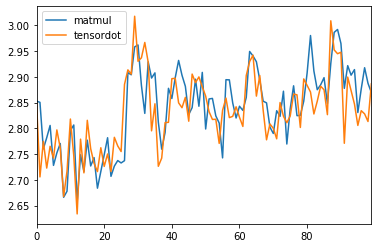

In [16]:
df.plot()

In [17]:
df["diff"] = df["matmul"] - df["tensordot"]

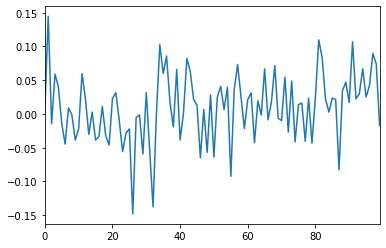

In [18]:
df["diff"].plot()

In [19]:
print("matmul mean: ",df["matmul"].mean())
print("tensordot mean: ",df["tensordot"].mean())

matmul mean:  2.8399088899999994
tensordot mean:  2.830473930000003


# T-test independence
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

**scipy.stats.ttest_ind**

This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

In [21]:
# test if the two samples are significantly different
# https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
from scipy.stats import ttest_ind

stat, p = ttest_ind(matmul_list, tensordot_list)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=0.891, p=0.374
Probably the same distribution


From the empirical test it seems that they have the same performance. Therefore the hypotesis is that they are using the same low level implementation. 

# Code analysis
**tensordot**
https://github.com/tensorflow/tensorflow/blob/r2.0/tensorflow/python/ops/math_ops.py#L3921-L4087

**matmul**
https://github.com/tensorflow/tensorflow/blob/r2.0/tensorflow/python/ops/math_ops.py#L2576-L2765

In [ ]:
#tensordot code
'''
with ops.name_scope(name, "Tensordot", [a, b, axes]) as name:
    a = ops.convert_to_tensor(a, name="a")
    b = ops.convert_to_tensor(b, name="b")
    a_axes, b_axes = _tensordot_axes(a, axes)
    a_reshape, a_free_dims, a_free_dims_static = _tensordot_reshape(a, a_axes)
    b_reshape, b_free_dims, b_free_dims_static = _tensordot_reshape(
        b, b_axes, True)
    ##### ----------------------------------------------- TENSORDOT is implemented with MATMUL
    ab_matmul = matmul(a_reshape, b_reshape) 
    ##### -----------------------------------------------
    if isinstance(a_free_dims, list) and isinstance(b_free_dims, list):
      return array_ops.reshape(ab_matmul, a_free_dims + b_free_dims, name=name)
    else:
      a_free_dims = ops.convert_to_tensor(a_free_dims, dtype=dtypes.int32)
      b_free_dims = ops.convert_to_tensor(b_free_dims, dtype=dtypes.int32)
      product = array_ops.reshape(
          ab_matmul, array_ops.concat([a_free_dims, b_free_dims], 0), name=name)
      if a_free_dims_static is not None and b_free_dims_static is not None:
        product.set_shape(a_free_dims_static + b_free_dims_static)
      return product
'''

Hypotesis confirmed: they have the **same low level implementation**